<a href="https://colab.research.google.com/github/atonui/makemore/blob/main/building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1&t=493s&ab_channel=AndrejKarpathy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

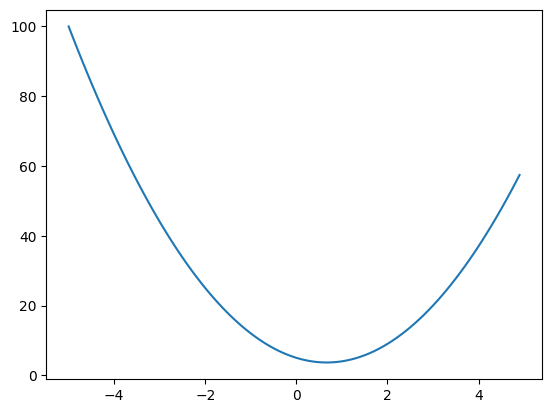

In [3]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

## What is a Deivative?

$$L = \lim_{x \to 0} \frac{f(a+h) - f(a)}{h}$$

If I slightly increase or decrease $f(a)$ how much does it change? What is it's sensitivity? Does it go up or down and by how much?

In [4]:
h = 0.0001 # a small change
x = 3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

20
20.001400030000006
14.000300000063248


In [5]:
h = 0.0001 # a small change
x = -3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

44
43.99780002999999
-21.999700000066014


In [6]:
h = 0.0001 # a small change
x = 2/3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

3.666666666666667
3.666666696666667
0.0002999999981767587


In [7]:
# a more complicated funtion
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [8]:
# applying the derivative to find out the effect of each variable on d
# a
h = 0.0001

a+=h
d1 = a*b + c
slope = (d1 - d)/(h)
print('d1: ', d)
print('slope: ', slope)

d1:  4.0
slope:  -3.000000000010772


Increasing $a$ by a small amount results in decreasing $d$ by -3.

In [9]:
# b
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

b+=h
d2 = a*b + c
slope2 = (d2 - d)/(h)
print('d2: ', d2)
print('slope: ', slope2)

d2:  4.0002
slope:  2.0000000000042206


increasing $b$ by a asmall amount results in increasing $d$ by 2.

In [10]:
# c
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

c+=h
d3 = a*b + c
slope3 = (d3 - d)/(h)
print('d3: ', d3)
print('slope: ', slope3)

d3:  4.0001
slope:  0.9999999999976694


Increasing $c$ by a small amount results in increasing $d$ by 1.

## Data Structure to Hold a Neuron

In [11]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # derivative of the outpul, L wrt this variable
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    '''print out a nice looking expression rather that the memory address'''
    return f"Value(Data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
a + b # a.add(b)
d = e + c ; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(Data=-8.0)

In [12]:
print(d._prev)
print(d._op)

{Value(Data=10.0), Value(Data=-6.0)}
+


In [13]:
# a way to visualise the mathematical expressions
from graphviz import Digraph

def trace(root):
  '''build a set of all nodes in a graph
  accepts an instance of the class Value
  and returns a set of all its node and edges'''
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this values is the result of some operation, create an op node for it
      dot.node(name=uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
     # connect n1 to the op node of n2
     dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

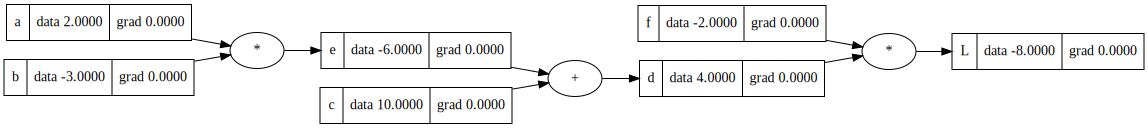

In [14]:
draw_dot(L)

This diagram above is our forward propagation. For the backpropagation, we have to find the derivative of all the terms wrt L

In [15]:
L.grad = 1.0 # derivative of L wrt to itself is 1

$$L = d*f$$
$$\frac{dL}{dd} = f$$
$$\frac{dL}{df} = d$$

In [16]:
# from above
f.grad = d.data
d.grad = f.data

$$d = c+e$$ \
$$\frac{dd}{dc} = 1$$ \
$$\frac{dd}{de} = 1$$

The derivative of a sum is one.

But how does $c$ or $e$ affect $L$?

Chain rule:
$$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} \: ∴ $$ \
$$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}$$ \
$$= f*1 = f$$ \
and:
$$\frac{dL}{de} = \frac{dL}{dd} * \frac{dd}{de}$$ \
$$= f*1 = f$$ \
Therfore we can conclude that a '+' node just routes backwards the gradient through because the local derivatives in a '+' node are always 1 i.e. it will distribute the incoming derivative to all it's children nodes.

In [17]:
# from above
c.grad = f.data
e.grad = f.data

$$e=a*b$$ \
$$\frac{de}{da}=b=-3.0$$ \
$$\frac{dL}{da} = \frac{dL}{de} * \frac{dd}{de}$$ \
$$\frac{dL}{de}=f=-2.0$$ \
$$\frac{de}{da}=b=-3.0$$


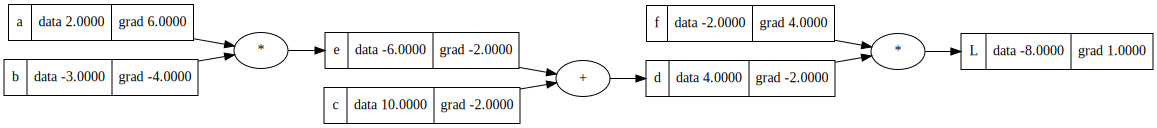

In [23]:
draw_dot(L)

In [22]:
a.grad = (f.data * b.data)
b.grad = (f.data * a.data)

In [19]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  a + b # a.add(b)
  d = e + c ; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  a + b # a.add(b)
  d = e + c ; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)
lol()

0.0
